In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable

## Data

In [2]:
%run utils.py

In [3]:
# %%time 
# metadata = pd.read_csv("../../Downloads/EOD_metadata.csv")
# data = get_data(metadata, 200)
# data.to_csv('stocks.csv', index=True)

In [25]:
DATA = pd.read_csv('stocks.csv', index_col=0)

## DBNT


In [5]:
class W():
    def __init__(self, shape=(1, 10), a0=1, c=1):
        self._shape = shape
        self._a0 = a0
        self._c = c
        self._W_start = np.random.randn(*shape)
        self._W_cur = self._W_start
        self.W_trace = [self._W_start]
        
    def _step(self):
        W = []
        
        gamma = np.random.gamma(self._a0, self._c)
        
        for row in range(self._shape[0]):
            W.append(np.random.multivariate_normal(self._W_cur[row], gamma * np.eye(self._shape[1])))
        
        self._W_cur = np.array(W).reshape(self._shape)
        self.W_trace.append(self._W_cur)
        
    def generate_W(self, n_iter):
        for i in range(n_iter):
            self._step()
            
        return np.array(self.W_trace)

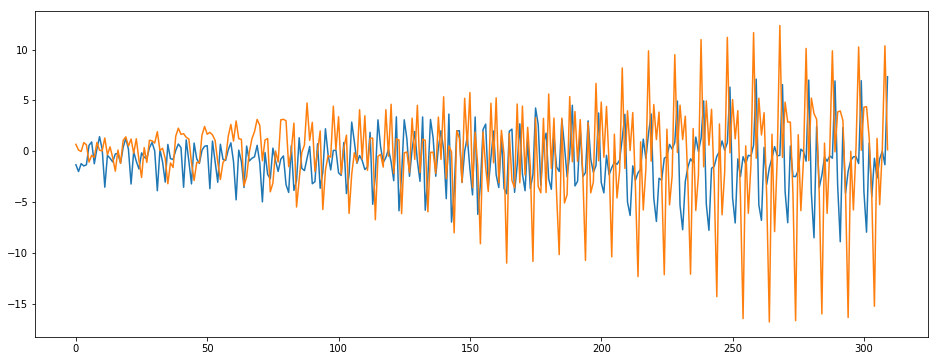

In [6]:
plt.figure(figsize=(16, 6))
m = W(shape=(2, 10))
d = m.generate_W(30)
plt.plot(d[:, 0].flatten())
plt.plot(d[:, 1].flatten())

In [17]:
class VAE(torch.nn.Module):
    def __init__(self, input_size, batch_size):
        super(VAE, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, input_size)
        
        self.H = Variable(torch.FloatTensor(np.random.randn(input_size, batch_size)))
        self.W = Variable(torch.FloatTensor(np.random.randn(input_size, input_size)))
        
        self.en_linear1 = nn.Linear(2 * input_size, 3)
        self.en_linear2 = nn.Linear(3, 2 * input_size)
        self.de_linear1 = nn.Linear(input_size, 3)
        self.de_linear2 = nn.Linear(3, 2 * input_size)
        
        self.relu = nn.ReLU()
        
        self.batch_size = batch_size
        self.input_size = input_size
        self.hidden = self.init_hidden(input_size, batch_size)

    def init_hidden(self, input_size, batch_size):
        return (torch.zeros(1, batch_size, input_size), torch.zeros(1, batch_size, input_size))
        
    def feedforward(self, x_j):
        return self.en_linear2(self.relu(self.en_linear1(x_j)))

    def feedforward2(self, x_j):
        return self.de_linear2(self.relu(self.de_linear1(x_j)))


    def encode(self, x):
        H_new = []
        x = x.transpose(0, 1).unsqueeze(0)
        S, self.hidden = self.lstm(x, self.hidden)
        
        assert S.size() == x.size()
        
        # loop over all columns
        for j, S_j in enumerate(S[0]):
            H_j =  self.H.transpose(0,1)[j] # take column
            y_j = torch.cat((S_j, H_j), 0) # concat 2 columns into 1 vector
            assert y_j.size()[0] == self.input_size * 2

            output = self.feedforward(y_j) # pass through feed forward network
            mu, std = output[:self.input_size], output[self.input_size:]
            
            H_j_new = self.reparam(mu, std) # sample H_j
            
            H_new.append(H_j_new)
            
        H_new = torch.stack(H_new)
        self.H = Variable(H_new.transpose(0, 1))
        return self.H
            
        
    def decode(self, H):
        x_new = []
        
        # loop over all columns
        for j, h_j in enumerate(H.transpose(0, 1)):
            Wh_j = self.W @ h_j
            assert Wh_j.size()[0] == self.input_size
            
            output = self.feedforward2(Wh_j) # pass through feed forward network
            mu, std = output[:self.input_size], output[self.input_size:]
            X_j_new = self.reparam(mu, std) # sample X_j
            
            x_new.append(X_j_new)
            
        x_new = torch.stack(x_new).transpose(0, 1)
        return x_new
            
        
    def reparam(self, mu, std):
        if self.training:
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu
            
    def forward(self, x):
        H = self.encode(x)
        return self.decode(H)
        

In [32]:
data = torch.tensor(DATA.T.values, dtype=torch.float)

In [39]:
batch_size = 16
model = VAE(input_size=data.shape[0], batch_size=batch_size)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

model.train()
for epoch in range(10):
    loss_sum = 0
    for i in range(data.shape[1] // batch_size):
        batch = Variable(data[:, i*batch_size: (i+1)*batch_size], requires_grad=False)
        optimizer.zero_grad()
        recon_batch = model(batch)
        loss = criterion(recon_batch, batch)
        loss.backward()
        optimizer.step()
        loss_sum += loss.data.numpy()
    print(loss_sum)

264493.12994384766
246437.23748779297
209467.14068603516
164730.89318847656
124333.26455688477
93755.79162597656
72739.74522399902
59281.58139038086
51167.30659484863
45886.538146972656
